In [65]:
%pip install -q pandas matplotlib numpy scipy

Note: you may need to restart the kernel to use updated packages.


Reading 20 files
Error computing measurements for file kp0.01-ki0.8-kd0.5.csv: index 0 is out of bounds for axis 0 with size 0
Error computing measurements for file kp0.01-ki0.8-kd0.0.csv: index 0 is out of bounds for axis 0 with size 0
Failed files: 20


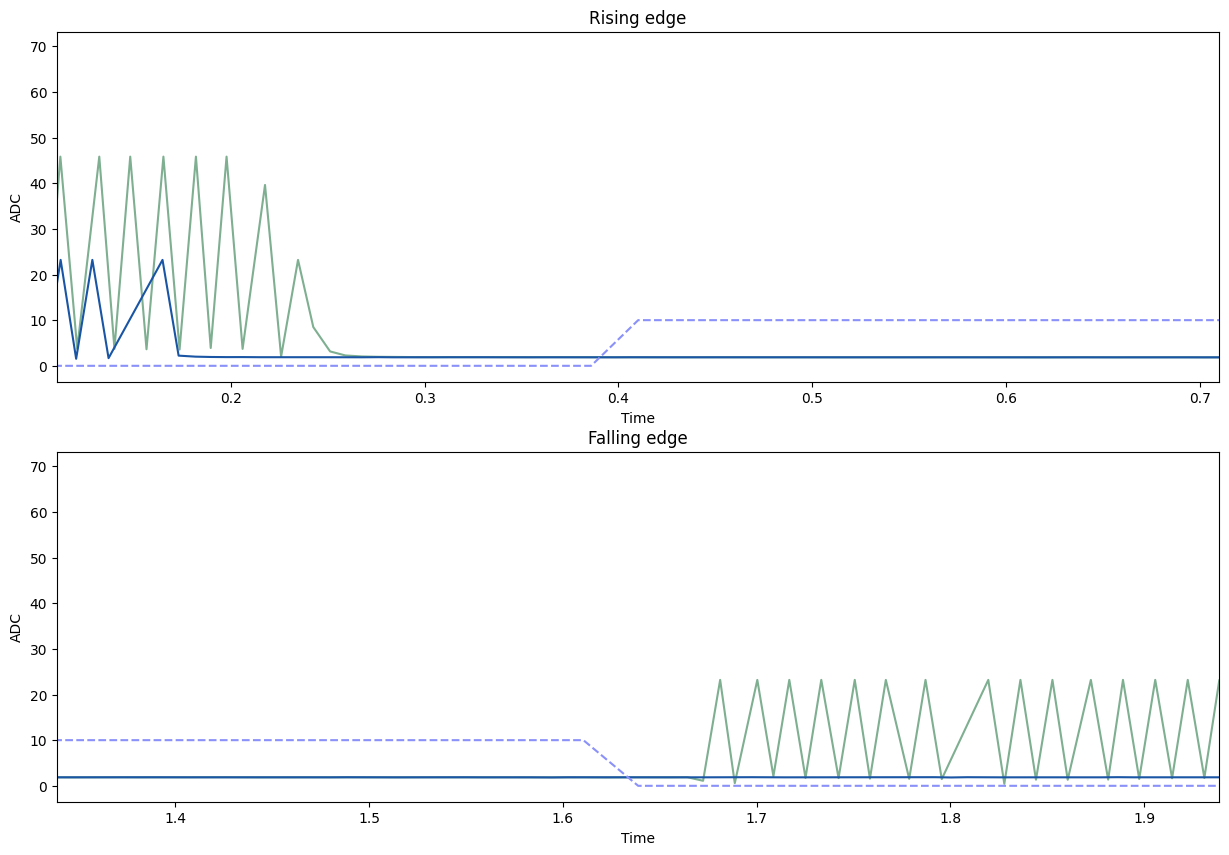

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

failed_files = 0

def compute_measurements(df):
	tolerance = 0.01
	peak_value = df.adc.max()

	setpoint_peak = df[df.setpoint == df.setpoint.max()]
	rise_start_time = setpoint_peak[setpoint_peak.adc >= 0.1 * peak_value].head(1).index[0]
	rise_end_time = df[df.adc >= 0.9 * peak_value].head(1).index[0]
	rise_time = rise_end_time - rise_start_time

	overshoot = (peak_value - df.setpoint.max()) / df.setpoint.max() * 100


	fall_start_time = df[df.adc >= 0.9 * peak_value ].tail(1).index[0]
	fall_end_time = df[(df.index.values >= fall_start_time) & (df.adc <= 0.1 * peak_value + df.setpoint)].head(1).index[0]
	fall_time = fall_end_time - fall_start_time


	df.reset_index(inplace=True)
	peaks = df.loc[signal.find_peaks(df.adc)[0]]
	df.set_index('time', inplace=True)



	damping_time = 0.0  # Not enough peaks to calculate
	if len(peaks) >= 2:
		# Get peaks that are on the tolerance band of the setpoint
		peaks = peaks[peaks.adc >= tolerance * df.setpoint.max() + df.setpoint.max()]
		if not peaks.tail(1).time.empty and not peaks.head(1).time.empty:
			damping_time = peaks.tail(1).time.values[0] - peaks.head(1).time.values[0]

	# Get the data between the last rising edge and the last falling edge
	df_step = df.loc[rise_end_time:fall_start_time]
	max_error = (df_step.setpoint - df_step.adc).abs().max()
	avg_error = (df_step.setpoint - df_step.adc).abs().mean()

	return {
		'peak_value': peak_value,
		'rise_time': rise_time,
		'fall_time': fall_time,
		'overshoot': overshoot,
		'damping_time': damping_time,
		'max_error': max_error,
		'avg_error': avg_error
	}


# Read all the data files from the data folder using pandas and plot the data using matplotlib
dir = "data"
files = os.listdir(dir)

# Cut window of data from the last rising edge to the last falling edge
window = 0.3

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

controllers = []
print(f"Reading {len(files)} files")
#i = 40

for file in files:
	try:
		# if i == 0:
		# 	break
		# i -= 1

		# Read constants from file name example kp24.0-ki195.1219512195122-kd2.05.csv
		filename = file[:-4]
		kp = float(filename.split('-')[0][2:])
		ki = float(filename.split('-')[1][2:])
		kd = float(filename.split('-')[2][2:])

		df = pd.read_csv(f"{dir}/{file}", index_col='time')

		df["kp"] = kp
		df["ki"] = ki
		df["kd"] = kd


	except Exception as e:
		print(f"Error reading file {file}: {e}")
		failed_files += 1
		continue

	
	# To be valid oscillation amplitude must be at least 10% of the setpoint
	amplitude = df[df.setpoint == df.setpoint.max()].adc.max() - df[df.setpoint == df.setpoint.max()].adc.min()
	if amplitude > 13.6:
		#print(f"Invalid data file {file}")
		failed_files += 1
		continue

	# Remove waveform that never reaches 75% of the setpoint
	if df.adc.max() < 0.75 * df.setpoint.max():
		#print(f"Invalid data file (setpoint) {file}")
		failed_files += 1
		continue



	color = np.random.rand(3,)
	label = f'kp={round(kp, 2)} ki={round(ki, 2)} kd={round(kd, 2)}'


	axs[0].plot(df.index, df.adc, label=f'{label} adc', color=color)
	axs[1].plot(df.index, df.adc, label=f'{label} adc', color=color)

	try:
		# Compute measurements
		measurements = compute_measurements(df)
		controller = measurements.copy()
	except Exception as e:
		print(f"Error computing measurements for file {file}: {e}")
		failed_files += 1
		continue

	# Add constants to the controller
	controller['kp'] = kp
	controller['ki'] = ki
	controller['kd'] = kd

	controller['data'] = df.copy()


	controllers.append(controller)
	


color = np.random.rand(3,)
axs[0].plot(df.index, df.setpoint, "--", label=f'setpoint',  color=color)
axs[1].plot(df.index, df.setpoint, "--", label=f'setpoint', color=color)

rising_edge = df[df.setpoint.diff() > 0].tail(1)
falling_edge = df[df.setpoint.diff() < 0].tail(1)

axs[0].set_xlim(rising_edge.index.values[0] - window, rising_edge.index.values[0] + window)
axs[0].set_xlim(rising_edge.index.values[0] - window, rising_edge.index.values[0] + window)

axs[1].set_xlim(falling_edge.index.values[0] - window, falling_edge.index.values[0] + window)
axs[1].set_xlim(falling_edge.index.values[0] - window, falling_edge.index.values[0] + window)
	

# Set labels and legend
axs[0].set_title('Rising edge')
axs[0].set_ylabel('Setpoint')
axs[0].set_ylabel('ADC')
axs[0].set_xlabel('Time')

axs[1].set_title('Falling edge')
axs[1].set_ylabel('Setpoint')
axs[1].set_ylabel('ADC')
axs[1].set_xlabel('Time')

#axs[0].legend()

print(f"Failed files: {failed_files}")








# Analising data

,peak_value,rise_time,fall_time,overshoot,damping_time,max_error,avg_error,kp,ki,kd,data,peak_value_normalized,rise_time_normalized,fall_time_normalized,overshoot_normalized,damping_time_normalized,avg_error_normalized,score,score_normalized
51,0.582414,0.000000,0.000000,-2.93100,0.000000,0.031436,0.024550,1.00,0.6,0.455556,setpoint adc control kp ...,0.041683,0.000000,0.000000,-0.006212,0.000000,0.006304,0.041775,0.015153
22,10.699905,0.000000,0.024575,6.99905,1.541715,9.875825,0.379214,0.23,0.0,0.366667,setpoint adc control kp ...,0.765780,0.000000,0.073275,0.014833,0.794090,0.097380,0.877993,0.318461
0,10.528258,0.016425,0.024502,5.28258,1.064690,9.187755,0.342056,0.01,0.4,0.233333,setpoint adc control kp ...,0.753495,0.057216,0.073058,0.011195,0.548389,0.087838,0.909744,0.329978
14,10.727606,0.016313,0.032806,7.27606,1.077342,9.231285,0.365226,0.01,0.0,0.233333,setpoint adc control kp ...,0.767762,0.056825,0.097819,0.015420,0.554906,0.093788,0.933795,0.338702
33,10.805267,0.024806,0.024643,8.05267,1.175472,9.548361,0.575676,0.01,0.2,0.233333,setpoint adc control kp ...,0.773320,0.086411,0.073479,0.017066,0.605450,0.147831,1.024628,0.371648
12,10.463954,0.000000,0.335377,4.63954,1.652356,9.711104,1.278849,0.23,0.0,0.100000,setpoint adc control kp ...,0.748893,0.000000,1.000000,0.009832,0.851078,0.328402,1.087127,0.394318
44,11.939024,0.016314,0.000000,19.39024,1.175824,1.939024,0.687994,0.01,0.4,0.277778,setpoint adc control kp ...,0.854462,0.056828,0.000000,0.041093,0.605631,0.176673,1.129056,0.409526
26,10.280436,0.024772,0.024611,2.80436,0.000000,9.680436,1.313387,0.01,0.0,0.188889,setpoint adc control kp ...,0.735759,0.086292,0.073382,0.005943,0.000000,0.337271,1.165265,0.422660
21,10.469395,0.024526,0.024341,4.69395,0.172298,9.869395,1.339825,0.01,0.0,0.144444,setpoint adc control kp ...,0.749282,0.085435,0.072577,0.009948,0.088746,0.344060,1.188726,0.431169
57,11.684275,0.016446,0.000000,16.84275,1.109678,1.684275,1.379895,0.01,0.2,0.277778,setpoint adc control kp ...,0.836230,0.057289,0.000000,0.035694,0.571561,0.354350,1.283563,0.465568


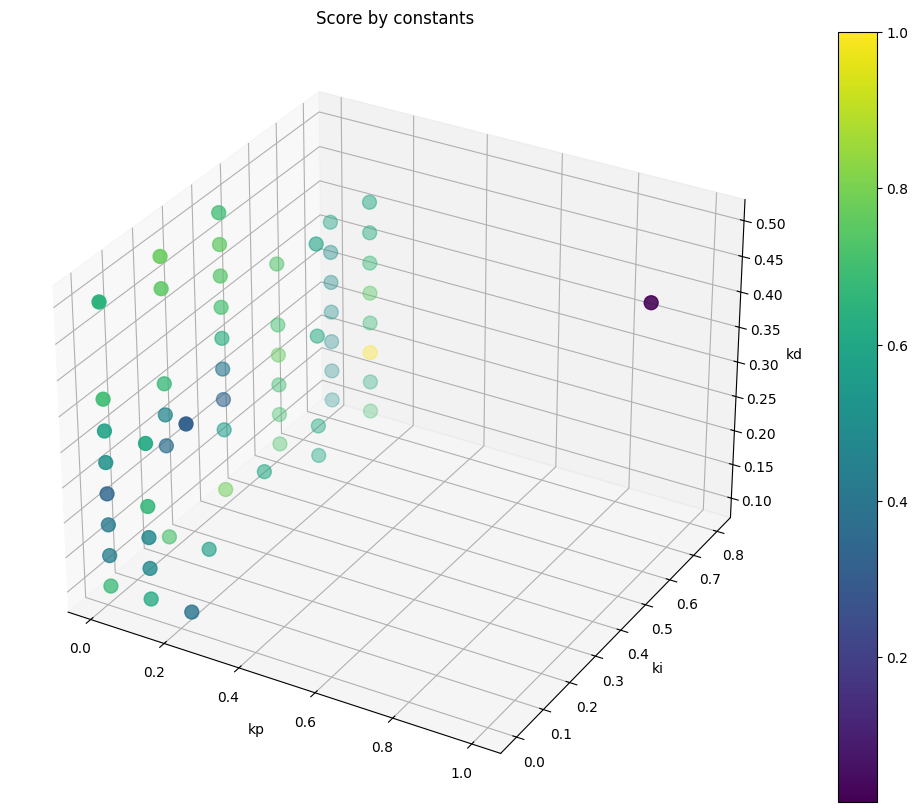

/tmp/ipykernel_194436/1337203832.py:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


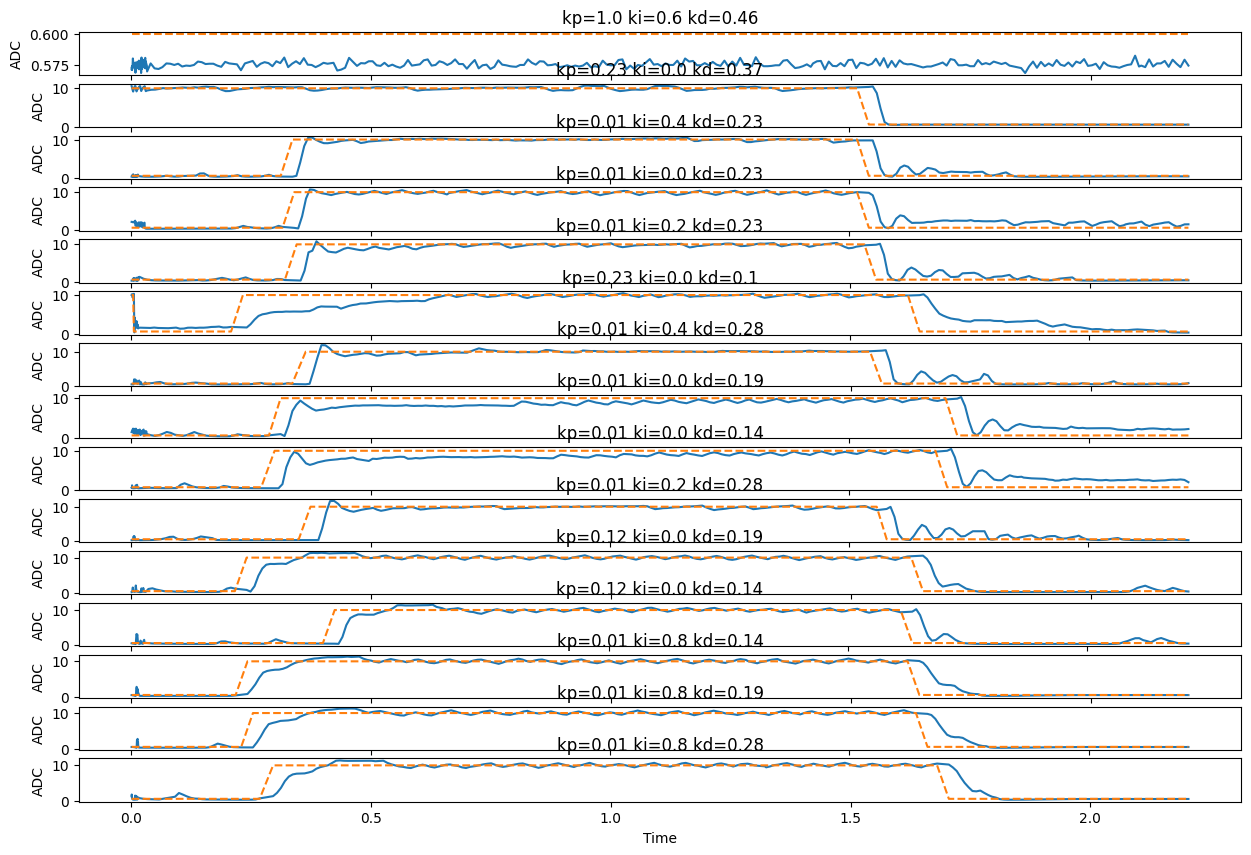

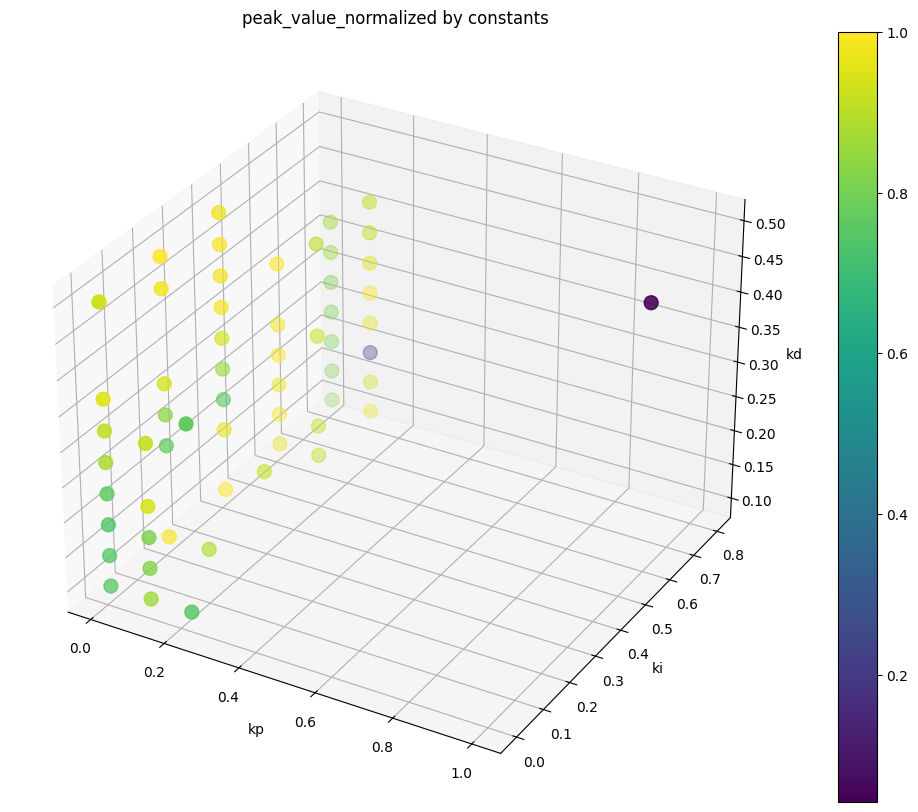

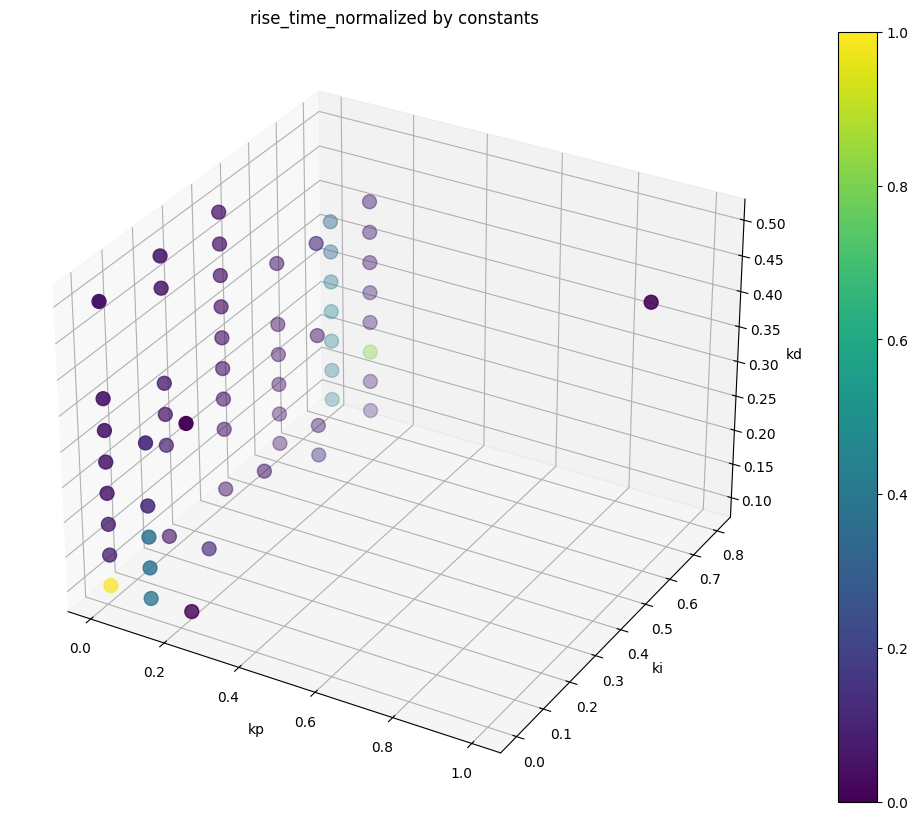

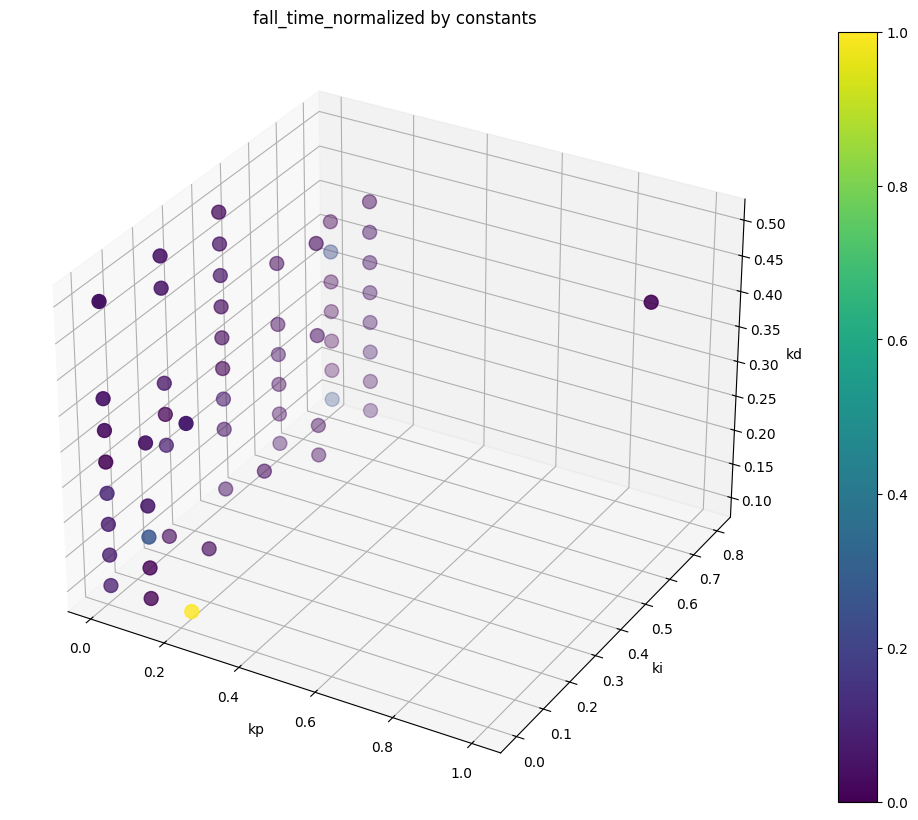

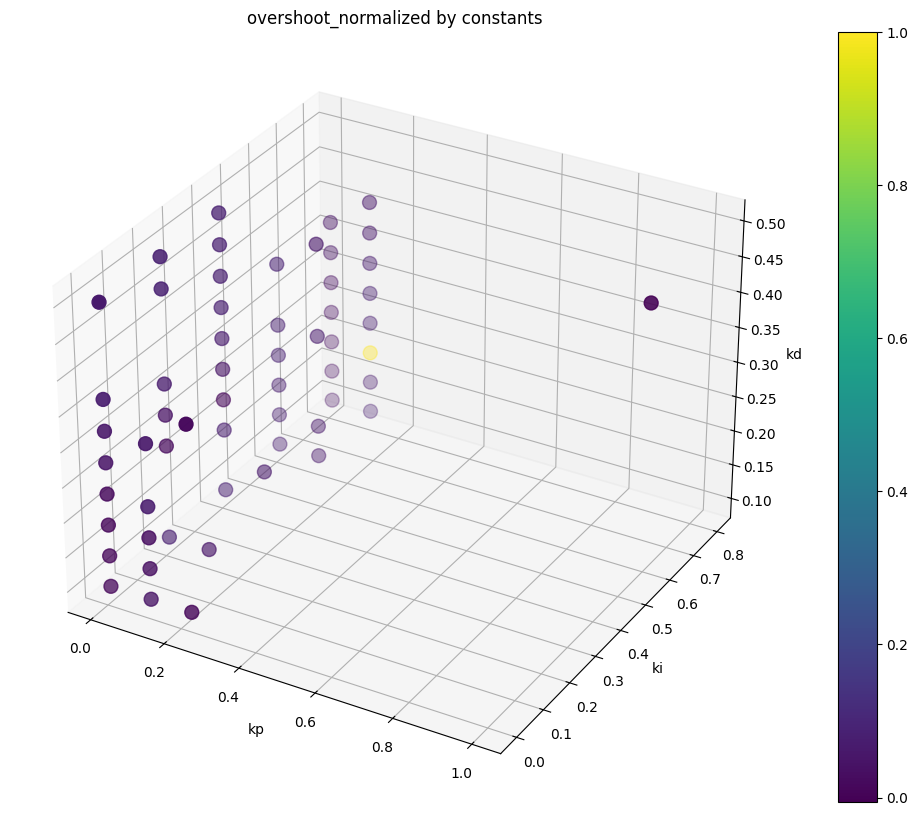

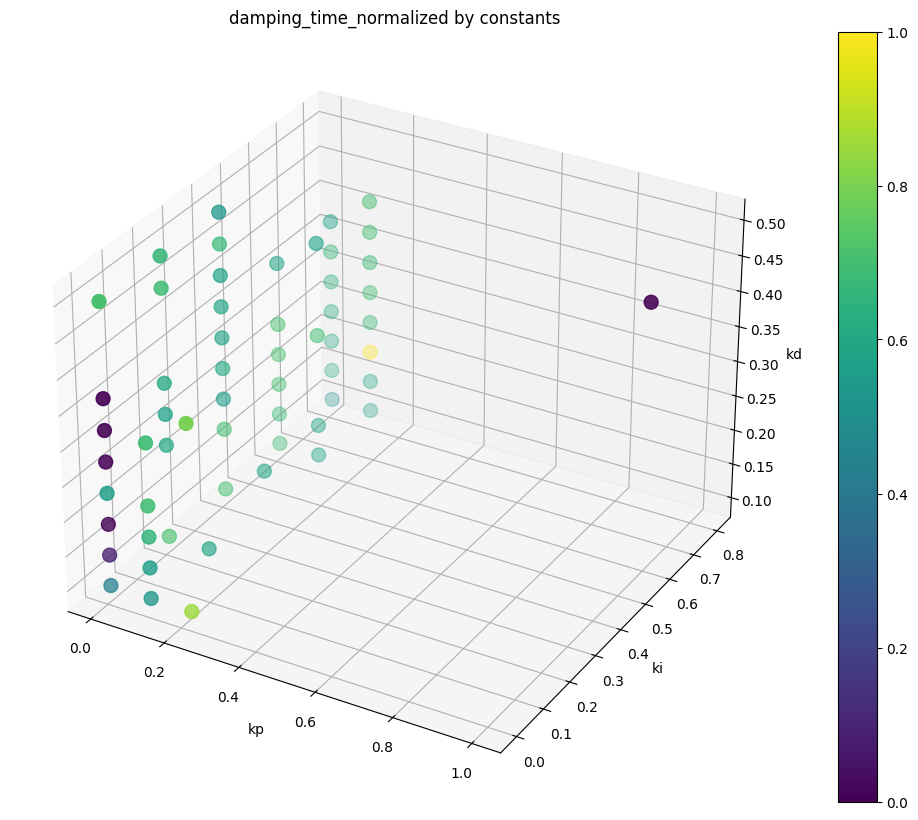

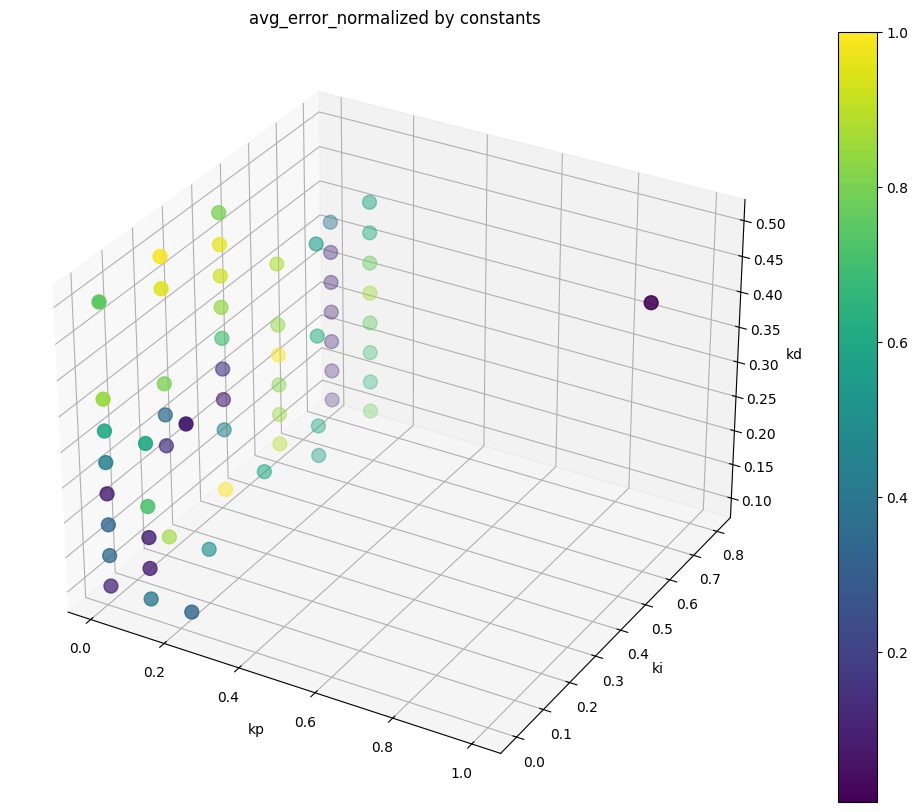

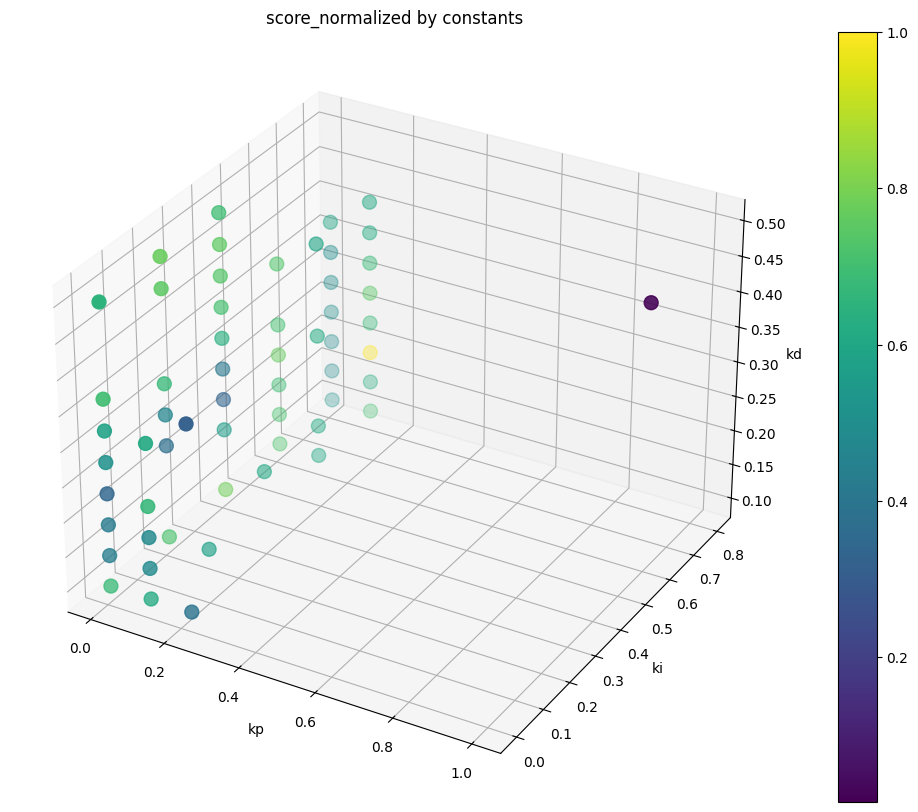

In [14]:
df = pd.DataFrame(controllers)

df = df.sort_values(by=['kp', 'ki', 'kd'])



# Normalize the data
df['peak_value_normalized'] = df['peak_value'] / df['peak_value'].max()
df['rise_time_normalized'] = df['rise_time'] / df['rise_time'].max()
df['fall_time_normalized'] = df['fall_time'] / df['fall_time'].max()
df['overshoot_normalized'] = df['overshoot'] / df['overshoot'].max()
df['damping_time_normalized'] = df['damping_time'] / df['damping_time'].max()
df['avg_error_normalized'] = df['avg_error'] / df['avg_error'].max()
df['score'] = df['peak_value_normalized'] + \
	df['rise_time_normalized'] + \
	df['overshoot_normalized'] + \
	df['avg_error_normalized']

# Normalize score
df['score_normalized'] = df['score'] / df['score'].max()

# Sort by score
df = df.sort_values(by=['score_normalized'])

display(df)

# Plot the score by the constants on a 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

plot = ax.scatter(df.kp, df.ki, df.kd, c=df.score_normalized, cmap='viridis', s=100)
ax.set_xlabel('kp')
ax.set_ylabel('ki')
ax.set_zlabel('kd')
ax.set_title('Score by constants')

fig.colorbar(plot, ax=ax)

plt.show()

# Plot best 5 controllers
fig, axs = plt.subplots(15, 1, figsize=(15, 10))

for i in range(15):
	controller = df.iloc[i]

	axs[i].plot(controller.data.index, controller.data.adc, label=f'adc')
	axs[i].plot(controller.data.index, controller.data.setpoint, "--", label=f'setpoint')
	#axs[i].plot(controller.data.index, controller.data.control, ".", label=f'setpoint')

	axs[i].set_title(f'kp={round(controller.kp, 2)} ki={round(controller.ki, 2)} kd={round(controller.kd, 2)}')
	axs[i].set_ylabel('ADC')
	axs[i].set_xlabel('Time')

fig.tight_layout()

# for any column with normalized in the name plot
columns = [col for col in df.columns if 'normalized' in col]

for column in columns:
	fig = plt.figure(figsize=(15, 10))
	ax = fig.add_subplot(111, projection='3d')

	plot = ax.scatter(df.kp, df.ki, df.kd, c=df[column], cmap='viridis', s=100)
	ax.set_xlabel('kp')
	ax.set_ylabel('ki')
	ax.set_zlabel('kd')
	ax.set_title(f'{column} by constants')

	fig.colorbar(plot, ax=ax)




	